In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import collections
import sys
sys.path.insert(0, '/data/programs/probe_position_correction_w_ptychonn/pppc')
sys.path.insert(0, '/data/programs/probe_position_correction_w_ptychonn')
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cupy
from skimage.transform import resize
import h5py
import tifffile

import tike
import tike.ptycho
import tike.view

/data/programs/tike/src/tike/communicators/mpi.py:414: UserWarning: tike was unable to import mpi4py, so MPI features are unavailable.
  warnings.warn(


In [3]:
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 14
plt.viridis()

<Figure size 640x480 with 0 Axes>

In [4]:
def calculate_pos_grad_error(pos1, pos2):
    g1 = pos1[1:] - pos1[:-1]
    g2 = pos2[1:] - pos2[:-1]
    g_mse = np.mean(np.sum((g2 - g1) ** 2, axis=1))
    return g_mse

In [13]:
scan_idx = '0_unscaled_reduced_4_22/nn_8_tol_3e-4_4e-4_variableTol_newErrorMap_unscaled'
save_figs = True
pos_corr = 0
record_intermediate_states = True
type = 'calculated'

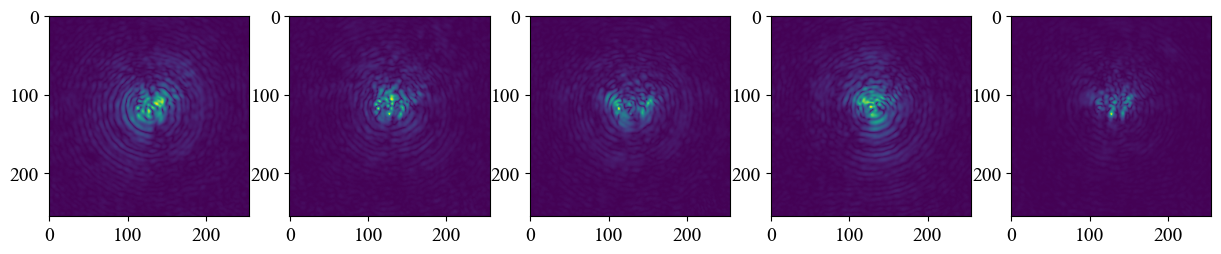

data size:  (1260, 256, 256)
probe size:  (5, 256, 256)
pos size:  (1260, 2)


In [14]:
fname_true_pos = 'data/test/pos_true_m_reduced_4_22.csv'
fname_baseline_pos = 'data/test/pos_baseline_m_reduced_4_22.csv'

f = h5py.File('data/test/data_raw_labelPsize_16_every2Rows_reduced_4_22.h5', 'r')
data_raw = f['exchange/data'][0]
probe_raw_mag = tifffile.imread('data/raw/probe_mag_ds_1.tiff')
probe_raw_phase = tifffile.imread('data/raw/probe_phase_ds_1.tiff')
probe_raw = probe_raw_mag * np.exp(1j * probe_raw_phase)
if type == 'true':
    probe_pos_list_raw = np.genfromtxt(fname_true_pos, delimiter=',')
elif type == 'calculated':
    probe_pos_list_raw = np.genfromtxt('outputs/test0_unscaled_reduced_4_22/nn_8_tol_3e-4_4e-4_variableTol_newErrorMap_unscaled/pos_iter_0.csv', delimiter=',')
elif type == 'baseline':
    probe_pos_list_raw = np.genfromtxt(fname_baseline_pos, delimiter=',')

fig, ax = plt.subplots(1, probe_raw.shape[0], figsize=(probe_raw.shape[0] * 3, 5))
for i in range(probe_raw.shape[0]):
    ax[i].imshow(np.abs(probe_raw[i, :, :]))
plt.show()

print('data size: ', data_raw.shape)
print('probe size: ', probe_raw.shape)
print('pos size: ', probe_pos_list_raw.shape)

psize nm: 13.2789376566526


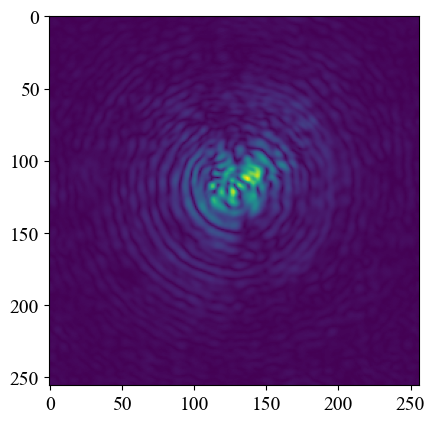

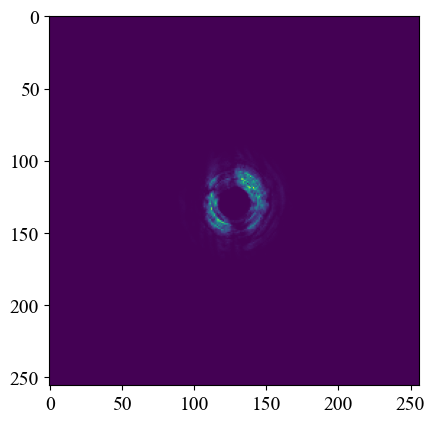

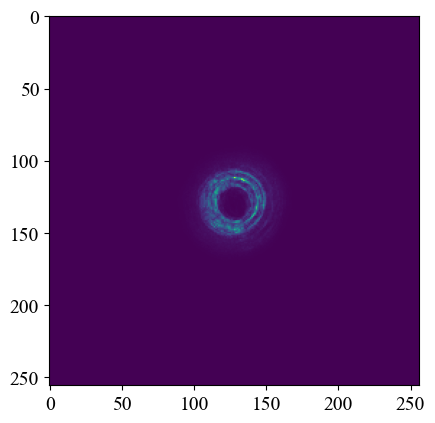

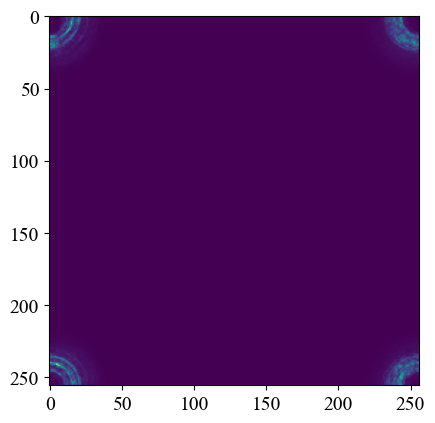

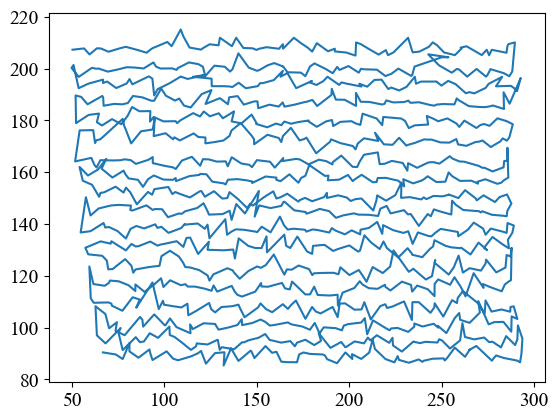

In [15]:
# Data transform:
# Use probe and pixel size in scan221_raw.npz. 
# If DP size is (256, 256), use as it is. (235, 247)
# If DP size is (512, 512), crop it to (256, 256) and flip left-right. 

psize_nm = f['metadata/psize_cm'][...] * 1e7
print('psize nm: {}'.format(psize_nm))

probe_pos_list = probe_pos_list_raw / (psize_nm * 1e-9)

data = data_raw
data = data.astype('float32')
data = np.fft.fftshift(data, axes=(-1, -2))

probe = probe_raw
#probe_real = transform_data_for_ptychonn(probe.real, target_shape=(256, 256), discard_len=None)
#probe_imag = transform_data_for_ptychonn(probe.imag, target_shape=(256, 256), discard_len=None)
#probe = probe_real + 1j * probe_imag

#probe = np.fft.fftshift(np.fft.ifft2(np.mean(data_raw, axis=0)))
probe = probe[np.newaxis, np.newaxis, :, :, :]
#probe = tike.ptycho.probe.add_modes_random_phase(probe, 6)

plt.imshow(np.abs(probe[0, 0, 0]))
plt.show()
plt.imshow(np.fft.ifftshift(np.abs(np.fft.fft2(probe[0, 0, 0])) ** 2))
plt.show()
plt.imshow(np.fft.ifftshift(data[0]))
plt.show()
plt.imshow(data[0])
plt.show()
plt.plot(probe_pos_list[:, 1], probe_pos_list[:, 0])

In [16]:
probe.shape, probe_pos_list.shape

((1, 1, 5, 256, 256), (1260, 2))

In [17]:
psi, probe_pos_list = tike.ptycho.object.get_padded_object(probe_pos_list, probe, extra=60)
print(psi.shape)

(508, 622)


In [18]:
num_epochs = 128
position_options = None
if pos_corr:
    position_options = tike.ptycho.PositionOptions(
        probe_pos_list,
        use_adaptive_moment=True,
        use_position_regularization=True,
        update_magnitude_limit=2,
        transform=tike.ptycho.position.AffineTransform(),
        optimize_scale=False  # Do NOT optimize scale
    )
    
parameters = tike.ptycho.PtychoParameters(
    # Provide initial guesses for parameters that are updated
    probe=probe,
    scan=probe_pos_list,
    psi=psi,
    probe_options=tike.ptycho.ProbeOptions(recover_probe=True), # uses default settings for probe recovery
    object_options=tike.ptycho.ObjectOptions(
        # The object will be updated.
        use_adaptive_moment=True,  # smoothness constraint will use our provided setting
        # other object options will be default values
    ),
    position_options=position_options,
    algorithm_options=tike.ptycho.RpieOptions(
        num_iter=num_epochs if not record_intermediate_states else 1,
        num_batch=7,
    ),
)

In [19]:
logging.basicConfig(level=logging.INFO)
probe_pos_history = []
if record_intermediate_states:
    for epoch in range(num_epochs):
        parameters = tike.ptycho.reconstruct(
            data=data,
            parameters=parameters,
            num_gpu=1
        )
        this_probe_pos = parameters.scan
        this_probe_pos = this_probe_pos - np.mean(this_probe_pos, axis=0)
        probe_pos_history.append(this_probe_pos)
        # plt.figure()
        # plt.plot(this_probe_pos[:, 1], this_probe_pos[:, 0], linewidth=0.5)
        # plt.plot(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], linewidth=0.5)
        # plt.show()
    result = parameters
else:
    # returns an updated PtychoParameters object
    result = tike.ptycho.reconstruct(
        data=data,
        parameters=parameters,
        num_gpu=1
    )

INFO:tike.ptycho.ptycho:rpie on 1,260 - 256 by 256 frames for at most 1 epochs.
INFO:tike.cluster:Clustering method is stripes.
INFO:tike.cluster:Clustering method is wobbly center.
INFO:tike.ptycho.ptycho:Probe rescaled by 126.382615
INFO:tike.ptycho.ptycho:rpie epoch 0
INFO:tike.ptycho.ptycho:The object update mean-norm is 1.931e-03
INFO:tike.ptycho.ptycho:  gaussian cost is +6.971e+00
INFO:tike.ptycho.ptycho:rpie on 1,260 - 256 by 256 frames for at most 1 epochs.
INFO:tike.cluster:Clustering method is stripes.
INFO:tike.cluster:Clustering method is wobbly center.
INFO:tike.ptycho.ptycho:Probe rescaled by 1.010036
INFO:tike.ptycho.ptycho:rpie epoch 1
INFO:tike.ptycho.ptycho:The object update mean-norm is 1.689e-03
INFO:tike.ptycho.ptycho:  gaussian cost is +5.637e+00
INFO:tike.ptycho.ptycho:rpie on 1,260 - 256 by 256 frames for at most 1 epochs.
INFO:tike.cluster:Clustering method is stripes.
INFO:tike.cluster:Clustering method is wobbly center.
INFO:tike.ptycho.ptycho:Probe rescaled

Plot loss history

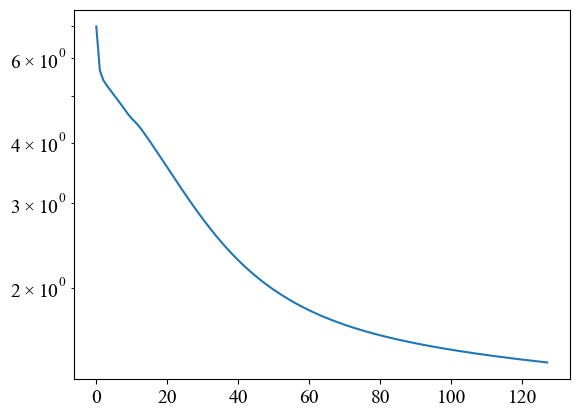

In [12]:
fig = plt.figure()
avg_cost = np.mean(np.stack(result.algorithm_options.costs, axis=0), axis=1)
plt.semilogy(avg_cost)
pos_corr_str = 'posCorr_1_clip_2' if pos_corr else 'posCorr_0'
if save_figs:
    if type == 'calculated':
        fig.savefig(os.path.join('outputs/test{}/loss_history_calc_pos_{}.pdf'.format(scan_idx, pos_corr_str)))
        np.savetxt(os.path.join('outputs/test{}/loss_history_calc_pos_{}.txt'.format(scan_idx, pos_corr_str)), avg_cost)
    elif type == 'true':
        fig.savefig(os.path.join('outputs/test{}/loss_history_true_pos.pdf'.format(scan_idx)))
        np.savetxt(os.path.join('outputs/test{}/loss_history_true_pos.txt'.format(scan_idx)), avg_cost)
    elif type == 'baseline':
        fig.savefig(os.path.join('outputs/test{}/loss_history_baseline_pos_{}.pdf'.format(scan_idx, pos_corr_str)))
        np.savetxt(os.path.join('outputs/test{}/loss_history_baseline_pos_{}.txt'.format(scan_idx, pos_corr_str)), avg_cost)
    else:
        raise ValueError
else:
    plt.show()


Plot reconstruction

(0.4445091-0.34280205j) (1.041472+0.32076132j)


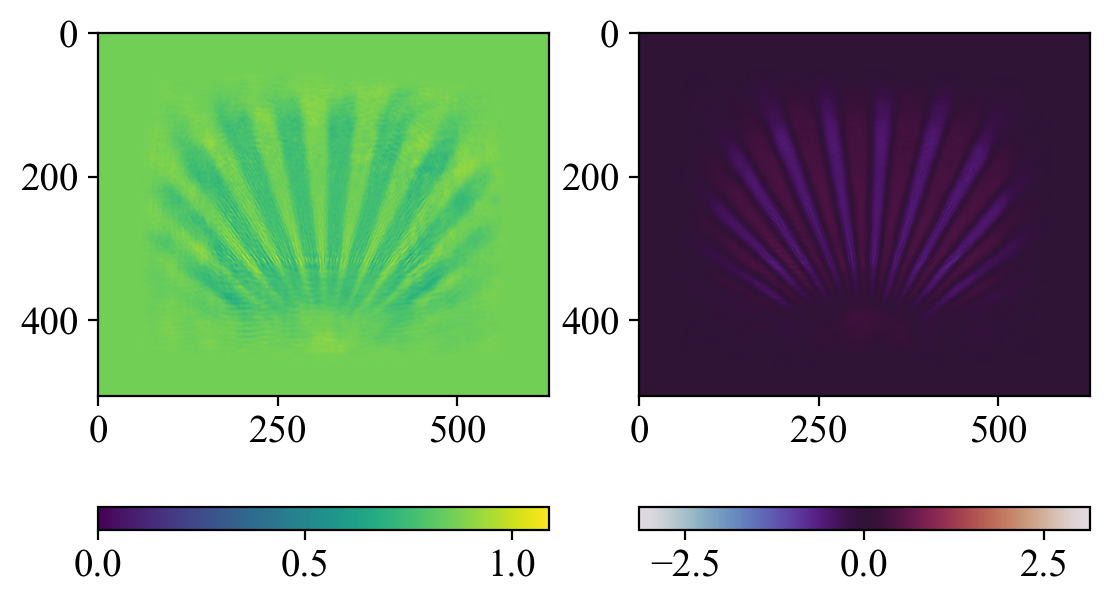

In [13]:
plt.figure(dpi=200)
tike.view.plot_phase(result.psi, amin=0)
plt.show()

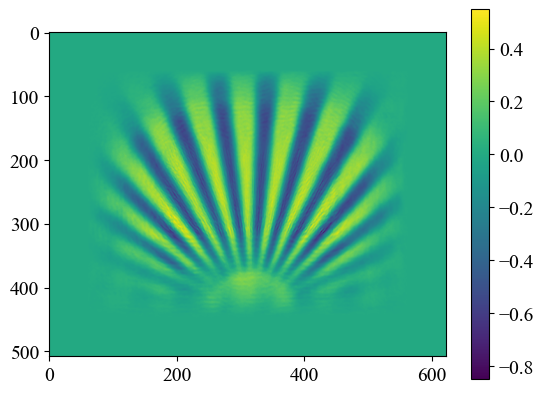

In [20]:
fig = plt.figure()
im = plt.imshow(np.angle(result.psi))
plt.colorbar(im)
pos_corr_str = 'posCorr_1_clip_2' if pos_corr else 'posCorr_0'
if save_figs:
    if type == 'calculated':
        fig.savefig('outputs/test{}/rpie_{}_pos_collective_niters_2_beta_0p5_nn_12_sw_1e-2_1e-3.pdf'.format(scan_idx, pos_corr_str))
        tifffile.imwrite('outputs/test{}/rpie_{}_pos_collective_niters_2_beta_0p5_nn_12_sw_1e-2_1e-3.tiff'.format(scan_idx, pos_corr_str), np.angle(result.psi))
    elif type == 'true':
        fig.savefig('outputs/test{}/rpie_posCorr_0_pos_true.pdf'.format(scan_idx))
        tifffile.imwrite('outputs/test{}/rpie_posCorr_0_pos_true.tiff'.format(scan_idx), np.angle(result.psi))
    elif type == 'baseline':
        fig.savefig('outputs/test{}/rpie_{}_pos_baseline.pdf'.format(scan_idx, pos_corr_str))
        tifffile.imwrite('outputs/test{}/rpie_{}_pos_baseline.tiff'.format(scan_idx, pos_corr_str), np.angle(result.psi))
    else:
        raise ValueError
else:
    plt.show()

Plot trajectories

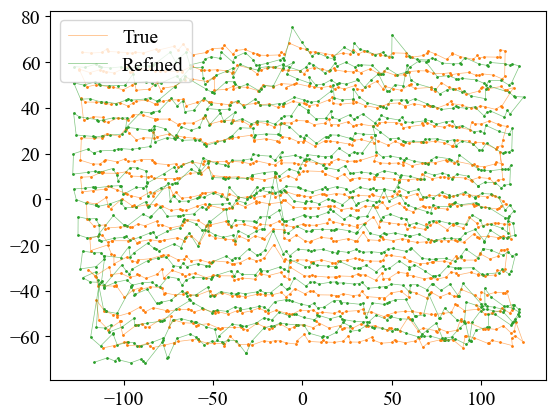

In [15]:
probe_pos_list_calc = probe_pos_list
probe_pos_list_true = np.genfromtxt(fname_true_pos, delimiter=',').astype('float32') / (psize_nm * 1e-9)
probe_pos_list_refined = result.scan
probe_pos_list_calc -= np.mean(probe_pos_list_calc, axis=0)
probe_pos_list_true -= np.mean(probe_pos_list_true, axis=0)
probe_pos_list_refined -= np.mean(probe_pos_list_refined, axis=0)
# probe_pos_list_raw *= 1.05
if type == 'calculated':
   plt.scatter(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], s=1, color=u'#1f77b4')
plt.scatter(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], s=1, color=u'#ff7f0e')
plt.scatter(probe_pos_list_refined[:, 1], probe_pos_list_refined[:, 0], s=1, color=u'#2ca02c')
if type == 'calculated':
    plt.plot(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], linewidth=0.5, alpha=0.6, label='Calculated', color=u'#1f77b4')
plt.plot(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], linewidth=0.5, alpha=0.6, label='True', color=u'#ff7f0e')
plt.plot(probe_pos_list_refined[:, 1], probe_pos_list_refined[:, 0], linewidth=0.5, alpha=0.6, label='Refined', color=u'#2ca02c')
plt.legend()
if save_figs and type == 'calculated' and pos_corr:
    plt.savefig('outputs/test{}/comparison_path_plot_true_calc_refined_clip_2_collective_iter_2_nn_12_sw_1e-3_1e-2.pdf'.format(scan_idx))
    np.savetxt('outputs/test{}/pos_refined_from_calc.csv'.format(scan_idx), probe_pos_list_refined * psize_nm * 1e-9, delimiter=',')
elif save_figs and type == 'baseline' and pos_corr:
    plt.savefig('outputs/test{}/comparison_path_plot_true_baseline.pdf'.format(scan_idx))
    np.savetxt('outputs/test{}/pos_refined_from_baseline.csv'.format(scan_idx), probe_pos_list_refined * psize_nm * 1e-9, delimiter=',')
else:
    plt.show()

In [16]:
import copy
result_old = copy.deepcopy(result)

Plot position gradient error history

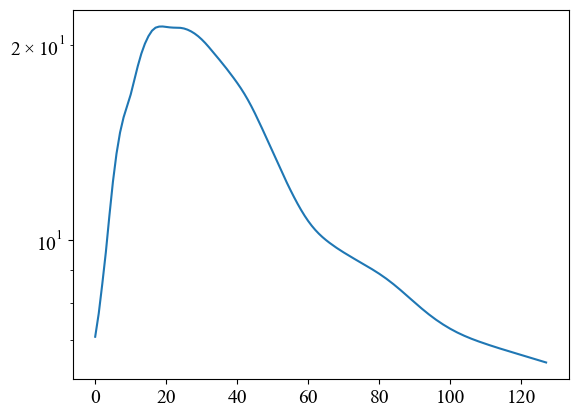

In [17]:
if type != 'true' and pos_corr and record_intermediate_states:
    pos_error_history = []
    for i_epoch, this_pos_list in enumerate(probe_pos_history):
        this_pos_list = this_pos_list - np.mean(this_pos_list, axis=0)
        pos_error_history.append(calculate_pos_grad_error(this_pos_list, probe_pos_list_true))
    plt.semilogy(pos_error_history)
    if save_figs:
        type_name = {'calculated': 'calc', 'true': 'true', 'baseline': 'baseline'}[type]
        np.savetxt(os.path.join('outputs/test{}/pos_grad_error_history_{}_pos_{}.txt'.format(
            scan_idx, type_name, pos_corr_str)),
            pos_error_history)


Plot position history

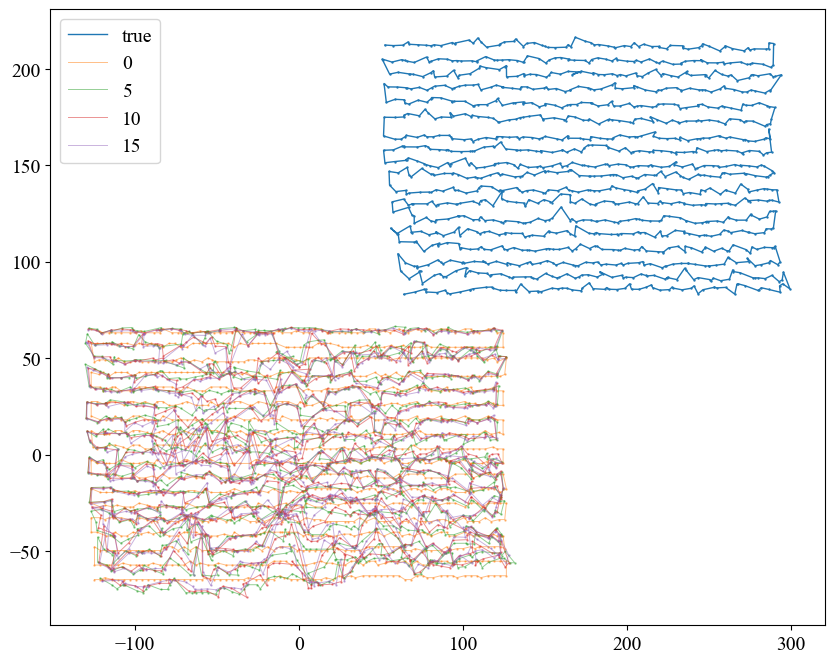

In [18]:
probe_pos_list_true = np.genfromtxt(fname_true_pos, delimiter=',').astype('float32') / (psize_nm * 1e-9)
plt.figure(figsize=(10, 8))
plt.scatter(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], s=0.5)
plt.plot(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], linewidth=1, label='true')
for i_epoch in range(len(probe_pos_history))[:20:5]:
    this_pos_list = probe_pos_history[i_epoch]
    plt.scatter(this_pos_list[:, 1], this_pos_list[:, 0], alpha=0.5, s=0.5)
    plt.plot(this_pos_list[:, 1], this_pos_list[:, 0], linewidth=0.7, alpha=0.5, label='{}'.format(i_epoch))
plt.legend()
if save_figs and pos_corr:
    plt.savefig('outputs/test{}/probe_pos_history.pdf'.format(scan_idx))
else:
    plt.show()